# Clustering weather stations in USA

A machine learning model is used to make `clusters` of weather stations of USA using the `DBSCAN clustering algorithm`.

Know more about `clustering` algorithms - [Source](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68).

![](https://media.giphy.com/media/26gsj2EoFmR8qf5PG/giphy.gif)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.utils
from mpl_toolkits.basemap import Basemap
from pylab import rcParams
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
# Loading the dataset
file_path = '/kaggle/input/weather-stations-in-usa/weather-stations20140101-20141231.csv'
df = pd.read_csv(file_path)
df.sample(5)

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
108,LUCY ISLAND LIGHTSTATION,54.296,-130.609,BC,6.9,0.0,NaN,11.3,0.0,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,311.7,0.0,1064728
319,PELLY ISLAND,69.633,-135.444,NT,-23.0,8.0,NaN,-5.7,7.0,-33.7,...,11.0,NaN,NaN,0.0,NaN,NaN,NaN,820.9,0.0,2203095
721,CYPRESS RIVER RCS,49.562,-99.074,MB,-18.7,0.0,NaN,-0.7,0.0,-34.7,...,1.0,NaN,NaN,2.0,NaN,NaN,NaN,1026.3,0.0,5010641
586,HIGH PRAIRIE AGDM,55.396,-116.479,AB,-9.9,0.0,NaN,8.3,0.0,-27.5,...,8.0,NaN,NaN,7.0,NaN,NaN,NaN,780.9,0.0,3063165
941,BELLEVILLE,44.151,-77.395,ON,-14.3,0.0,-9.2,-2.0,0.0,-33.0,...,0.0,88.0,40.0,15.0,NaN,NaN,NaN,904.6,0.0,6150689


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Stn_Name  1341 non-null   object 
 1   Lat       1341 non-null   float64
 2   Long      1341 non-null   float64
 3   Prov      1341 non-null   object 
 4   Tm        1256 non-null   float64
 5   DwTm      1256 non-null   float64
 6   D         357 non-null    float64
 7   Tx        1260 non-null   float64
 8   DwTx      1260 non-null   float64
 9   Tn        1260 non-null   float64
 10  DwTn      1260 non-null   float64
 11  S         586 non-null    float64
 12  DwS       586 non-null    float64
 13  S%N       198 non-null    float64
 14  P         1227 non-null   float64
 15  DwP       1227 non-null   float64
 16  P%N       209 non-null    float64
 17  S_G       798 non-null    float64
 18  Pd        1227 non-null   float64
 19  BS        0 non-null      float64
 20  DwBS      0 non-null      floa

## Data preparation

In [4]:
# Removing the rows that don't have any value for the 'Tm' field
df = df[pd.notnull(df['Tm'])]
df = df.reset_index(drop=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


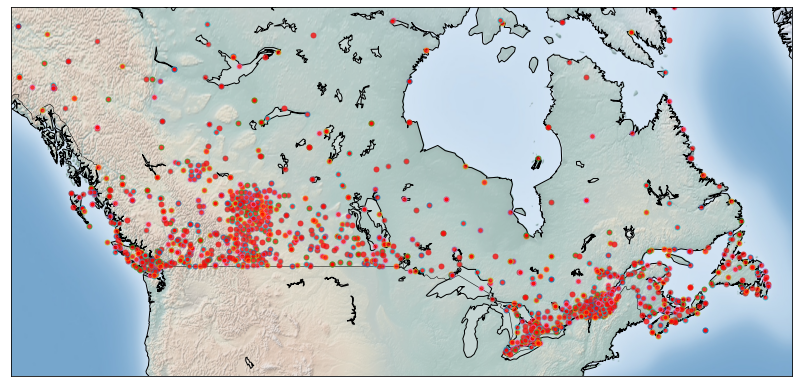

In [5]:
# Plotting map and weather stations on map
def plot_map(df):
    rcParams['figure.figsize'] = (14, 10)

    llon = -140
    ulon = -50
    llat = 40
    ulat = 65

    df = df[(df['Long'] > llon) & (df['Long'] < ulon) & (df['Lat'] > llat) & (df['Lat'] < ulat)]

    my_map = Basemap(
        projection='merc',
        resolution='l',
        area_thresh=1000.0,
        llcrnrlon=llon,
        llcrnrlat=llat,  # min longitude (llcrnrlon) and latitude (llcrnrlat)
        urcrnrlon=ulon,
        urcrnrlat=ulat
    )  # max longitude (urcrnrlon) and latitude (urcrnrlat)

    my_map.drawcoastlines()
    my_map.drawcountries()
    # my_map.drawmapboundary()
    my_map.fillcontinents(color='white', alpha=0.3)
    my_map.shadedrelief()

    # To collect data based on stations

    xs, ys = my_map(np.asarray(df.Long), np.asarray(df.Lat))
    df['xm'] = xs.tolist()
    df['ym'] = ys.tolist()

    # Visualization1
    for index, row in df.iterrows():
        #   x,y = my_map(row.Long, row.Lat)
        my_map.plot(
            row.xm,
            row.ym,
            markerfacecolor=([1, 0, 0]),
            marker='o',
            markersize=5,
            alpha=0.75
        )

    # plt.text(x,y,stn)
    plt.show()

    return ((llon, ulon, llat, ulat), df)

(llon, ulon, llat, ulat), df = plot_map(df.copy())

## Modelling

### Clustering the station based on their locations i.e. `Latitude and Longitude`

In [6]:
sklearn.utils.check_random_state(1000)

RandomState(MT19937) at 0x7FDAD00F6380

**Getting dataset**

In [7]:
Clus_dataSet = df[['xm', 'ym']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)

scaler = StandardScaler()
Clus_dataSet = scaler.fit_transform(Clus_dataSet)

Clus_dataSet

array([[-1.16833902, -0.33176141],
       [-1.18518021, -0.35499148],
       [-1.18169137, -0.35394619],
       ...,
       [ 1.46577713,  1.86125634],
       [ 1.64788589,  0.95789607],
       [ 1.2814717 ,  0.53978899]])

**Compute DBSCAN**

In [8]:
db = DBSCAN(eps=0.15, min_samples=10)
db.fit(Clus_dataSet)

DBSCAN(eps=0.15, min_samples=10)

In [9]:
print(set(db.labels_)) # unique clusters
db.labels_

{0, 1, 2, 3, 4, -1}


array([ 0,  0,  0, ..., -1, -1, -1])

**Distinguish Outliers**

In [10]:
# Lets Replace all elements with 'True' in core_samples_mask that are in the cluster, 'False' if the points are outliers.
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
core_samples_mask

array([ True,  True,  True, ..., False, False, False])

In [11]:
labels = db.labels_
df['Clus_Db'] = labels
df[['Clus_Db']].head()

,Clus_Db
0,0
1,0
2,0
3,0
4,0


In [12]:
# Number of clusters in labels, ignoring noise if present.
realClusterNum = len(set(labels)) - (1 if -1 in labels else 0)

# Remove repetition in labels by turning it into a set.
clusterNum = len(set(labels))

# A sample of clusters
df[['Stn_Name', 'Tx', 'Tm', 'Clus_Db']].head(5)

,Stn_Name,Tx,Tm,Clus_Db
0,CHEMAINUS,13.5,8.2,0
1,COWICHAN LAKE FORESTRY,15.0,7.0,0
2,LAKE COWICHAN,16.0,6.8,0
3,DUNCAN KELVIN CREEK,14.5,7.7,0
4,ESQUIMALT HARBOUR,13.1,8.8,0


In [13]:
set(labels)

{-1, 0, 1, 2, 3, 4}

Cluster 0, Avg Temp: -5.538747553816051
Cluster 1, Avg Temp: 1.9526315789473685
Cluster 2, Avg Temp: -9.195652173913045
Cluster 3, Avg Temp: -15.300833333333333
Cluster 4, Avg Temp: -7.769047619047619


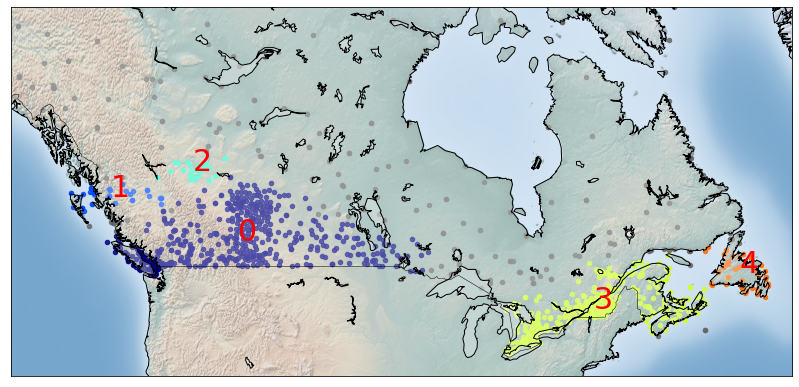

In [14]:
# Visualisation of clusters based on location
def plot_clusters_map(llon, ulon, llat, ulat, labels):
    rcParams['figure.figsize'] = (14, 10)

    my_map = Basemap(
        projection='merc',
        resolution='l',
        area_thresh=1000.0,
        llcrnrlon=llon,
        llcrnrlat=llat,  # min longitude (llcrnrlon) and latitude (llcrnrlat)
        urcrnrlon=ulon,
        urcrnrlat=ulat
    )  # max longitude (urcrnrlon) and latitude (urcrnrlat)

    my_map.drawcoastlines()
    my_map.drawcountries()
    #my_map.drawmapboundary()
    my_map.fillcontinents(color='white', alpha=0.3)
    my_map.shadedrelief()

    # To create a color map
    colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))

    #Visualization1
    for clust_number in set(labels):
        c = (
            ([0.4, 0.4, 0.4])
            if clust_number == -1 else colors[np.int(clust_number)]
        )
        clust_set = df[df.Clus_Db == clust_number]
        my_map.scatter(
            clust_set.xm, clust_set.ym, color=c, marker='o', s=20, alpha=0.85
        )
        if clust_number != -1:
            cenx = np.mean(clust_set.xm)
            ceny = np.mean(clust_set.ym)
            plt.text(
                cenx,
                ceny,
                str(clust_number),
                fontsize=30,
                color='red',
            )
            print(
                "Cluster " + str(clust_number) + ', Avg Temp: ' +
                str(np.mean(clust_set.Tm))
            )


plot_clusters_map(llon, ulon, llat, ulat, labels)

### Clustering of stations based on their `location`, `mean`, `max`, and `min` `Temperature`

**Getting dataset**

In [15]:
# In this section we re-run DBSCAN, but this time on a 5-dimensional dataset
Clus_dataSet = df[['xm', 'ym', 'Tx', 'Tm', 'Tn']]

In [16]:
# Data wrangling 
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

**Compute DBSCAN**

In [17]:
db = DBSCAN(eps=0.3, min_samples=10).fit(Clus_dataSet)

**Distinguish Outliers**

In [18]:
# Lets Replace all elements with 'True' in core_samples_mask that are in the cluster, 'False' if the points are outliers.
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

labels = db.labels_
df['Clus_Db'] = labels

# Number of clusters in labels, ignoring noise if present.
realClusterNum = len(set(labels)) - (1 if -1 in labels else 0)

# Remove repetition in labels by turning it into a set.
clusterNum = len(set(labels))

# A sample of clusters
df[['Stn_Name', 'Tx', 'Tm', 'Clus_Db']].head(5)

,Stn_Name,Tx,Tm,Clus_Db
0,CHEMAINUS,13.5,8.2,0
1,COWICHAN LAKE FORESTRY,15.0,7.0,0
2,LAKE COWICHAN,16.0,6.8,0
3,DUNCAN KELVIN CREEK,14.5,7.7,0
4,ESQUIMALT HARBOUR,13.1,8.8,0


Cluster 0, Avg Temp: 6.2211920529801334
Cluster 1, Avg Temp: 6.790000000000001
Cluster 2, Avg Temp: -0.49411764705882355
Cluster 3, Avg Temp: -13.877209302325586
Cluster 4, Avg Temp: -4.186274509803922
Cluster 5, Avg Temp: -16.301503759398482
Cluster 6, Avg Temp: -13.599999999999998
Cluster 7, Avg Temp: -9.753333333333334
Cluster 8, Avg Temp: -4.258333333333334


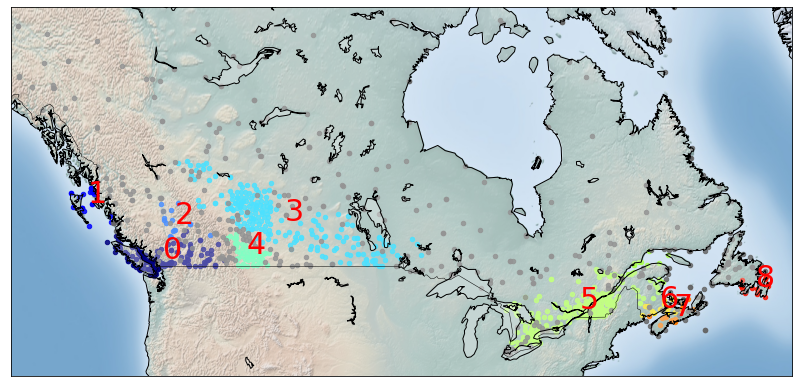

In [19]:
plot_clusters_map(llon, ulon, llat, ulat, labels)

### Helper function for the model

In [20]:
def model(df, dataset, eps=0.15, min_samples=10):
    dataset = np.nan_to_num(dataset)
    
    # Scaling the dataset
    dataset = StandardScaler().fit_transform(dataset)
    
    # Computer DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(dataset)
    
    # Distinguish outliers

    # Lets Replace all elements with 'True' in core_samples_mask that are in the cluster, 'False' if the points are outliers.
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    labels = db.labels_
    df['Clus_Db'] = labels

    # Number of clusters in labels, ignoring noise if present.
    real_cluster_num = len(set(labels)) - (1 if -1 in labels else 0)

    # Remove repetition in labels by turning it into a set.
    cluster_num = len(set(labels))

    # Number of clusters in labels, ignoring noise if present.
    real_cluster_num = len(set(labels)) - (1 if -1 in labels else 0)
    
    print(f'Unique clusters: {set(labels)}')
    
    return (df, dataset, labels, core_samples_mask, db)

Unique clusters: {0, 1, 2, 3, 4, -1}
Cluster 0, Avg Temp: -5.538747553816051
Cluster 1, Avg Temp: 1.9526315789473685
Cluster 2, Avg Temp: -9.195652173913045
Cluster 3, Avg Temp: -15.300833333333333
Cluster 4, Avg Temp: -7.769047619047619


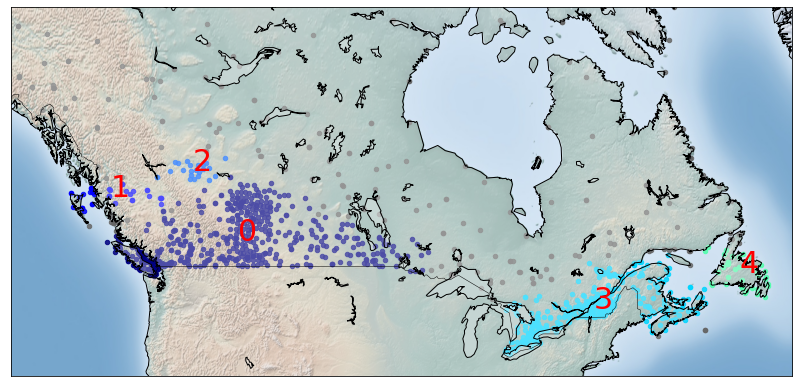

In [21]:
dataset = df[['xm', 'ym']]
_, _, labels, _, _ = model(df, dataset)
plot_clusters_map(llon, ulon, llat, ulat, labels)

---

I'll wrap things up there. If you want to find some other answers then go ahead `edit` this kernel. If you have any `questions` then do let me know.

If this kernel helped you then don't forget to 🔼 `upvote` and share your 🎙 `feedback` on improvements of the kernel.

![](https://media.giphy.com/media/xT5LMIp6EnVSEwLUYg/giphy.gif)

---